# 💹  Multivariate Stock Price Prediction - LSTM

This project implements a time series multivariate analysis using RNN/LSTM for stock price predictions. A deep RNN model was created and trained on five years of historical Google stock price data to forecast the stock performance over a two-month period.

## 👥Development Team
- `Aakaash M S`
- `Karthik Ram S`
- `Aniketha Prasad`
- `Riya Rajesh`

## 🏗️ High-Level Architecture

![Alt Text](../assets/highLevel.png)


## PHASE 1 : Exploratory Data Analysis

### Loading necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import load_model

### Loading the dataset

In [ ]:
# Data file location and Loading the dataset
data_file_location = "..\\data\\raw\\"
data_file_name = "google_stock_price_full"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

In [ ]:
#sample
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2891,2016-02-12,34.513000,34.687500,33.930000,34.119999,34.119999,42828000
3122,2017-01-12,40.356998,40.369499,39.958500,40.318001,40.318001,27062000
4280,2021-08-19,135.467499,137.451996,135.356003,136.913498,136.913498,18296000
930,2008-04-30,14.002764,14.566900,13.909613,14.303636,14.303636,317304895
4169,2021-03-12,104.250000,104.513000,102.377502,103.096001,103.096001,34516000


In [ ]:
# Shape of the dataset
print("Number of rows:",data.shape[0])
print("Number of columns:",data.shape[1])

Number of rows: 4940
Number of columns: 7


In [ ]:
# Data types

In [ ]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

## Data cleaning

In [ ]:
# Convert Date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
# Check column format
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

### Dataset exploration

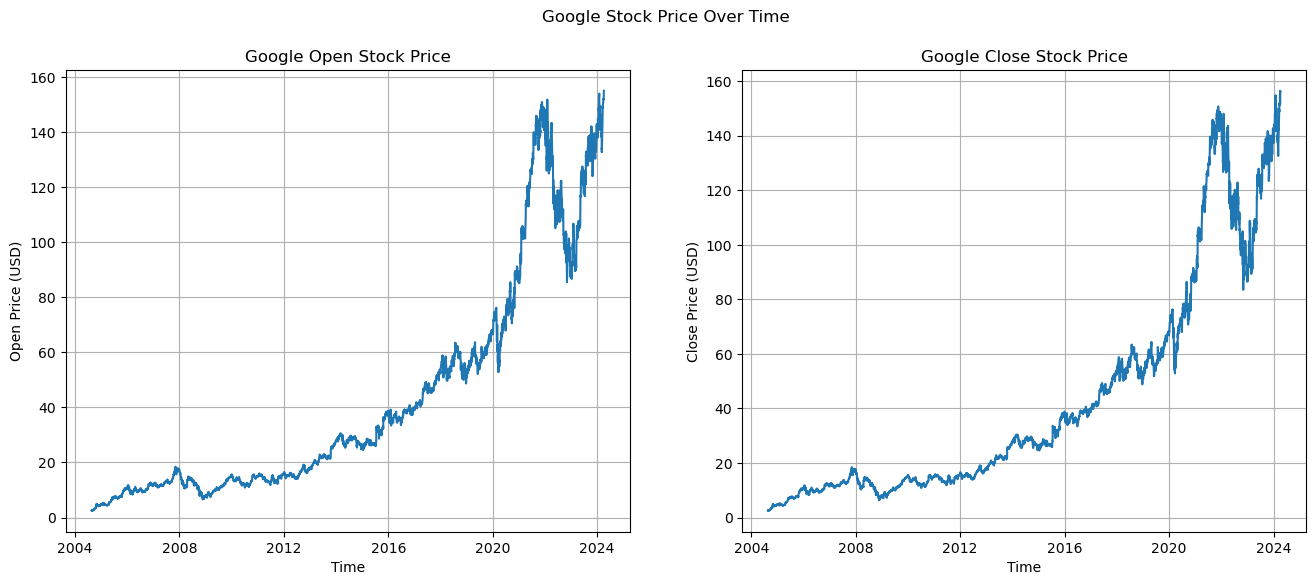

In [ ]:
# Plot of Open and Close price for the whole period
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

The previous charts show an inconsistent behavior in the stock's performance over time, with a completely distinct trend during the past five years.

This means that the old historical data might not be relevant to the predictions, since it's most likely to represents a different period with outdated indicators that don't affect the current trend.

Accordingly, we will concentrate our analysis on the most recent five-year data, as it is expected to provide more accurate insights for predicting future trends.

In [ ]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Filtered data shape
data_5years.shape

(1323, 7)

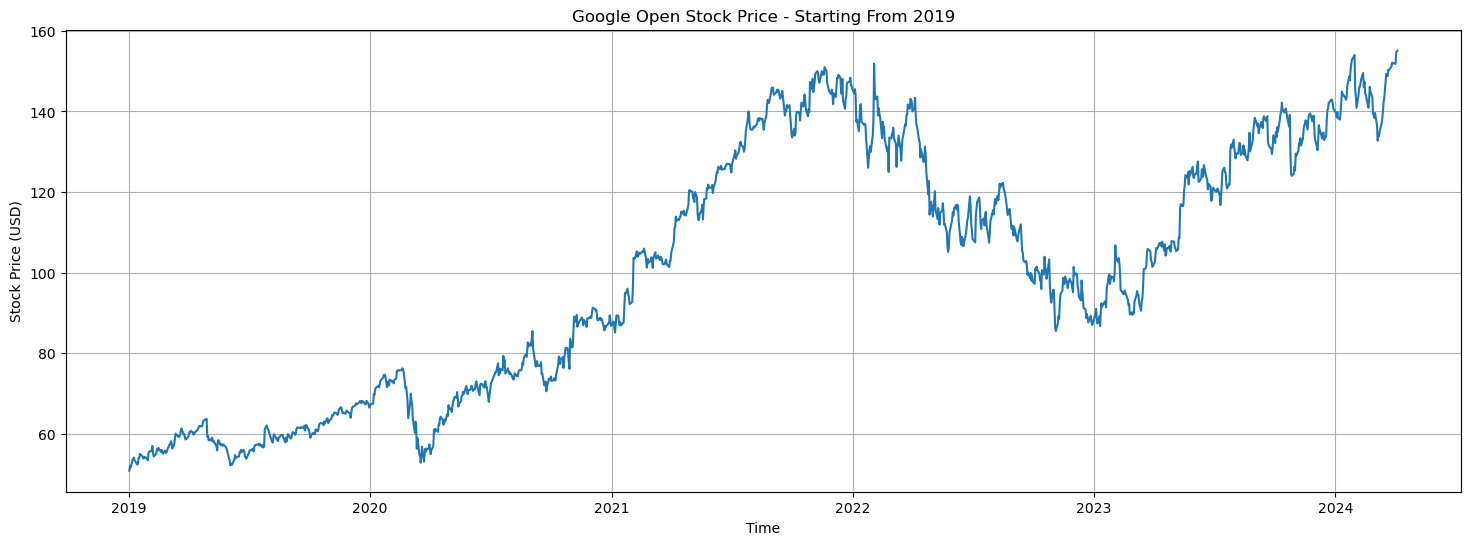

In [ ]:
# Plot for Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Google Open Stock Price - Starting From 2019")
plt.grid()

### Filtering the dataset

In [ ]:
# Preparing data file location
data_file_location = "..//data//interim//"
data_file_name = "google_stock_price_recent"
data_file_ext = "csv"

# Storing dataset
data_5years.to_csv(data_file_location + data_file_name + "." + data_file_ext, index=None)

## PHASE 2 : Data Preprocessing

### Loading necessary libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [ ]:
# Set output width
pd.set_option("display.width", 120)

### Loading the dataset

In [ ]:
# Prepare data file location and name
data_file_location = "..//data//interim//"
data_file_name = "google_stock_price_recent"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

In [ ]:
# Check loaded data shape
data.shape

(1323, 7)

In [ ]:
# Check loaded data head
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
1,2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2,2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
3,2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
4,2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000


In [ ]:
# Check columns types
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### Data preprocessing

In [ ]:
# Convertig date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

#### Select Independent Features
The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables:

- Opening price
- Highest price
- Lowest price
- Closing price
- Adjusted closing price
- Trading volume

These features will be utilized to forecast the future opening price.

In [ ]:
# Defining selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

#### Creating Train, Validation, and Test Datasets
To monitor and assess the performance of our model, we will partition the recent stock price dataset into three segments: training, validation, and testing sets.

The division will be structured as follows:

- **Training dataset:** covering the period from the start of 2019 till June, 2023.
- **Validation dataset:** representing the stock prices from July, 2023 till the end of 2023.
- **Testing dataset:** representing the stock prices for the first two months of 2024.

In [ ]:
# Defining start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Splitting dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [ ]:
# Shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1132, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


In [ ]:
# Summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Open       High        Low      Close  Adj Close    Volume
0  50.828499  52.616001  50.785500  52.292500  52.292500  30652000
1  52.049999  52.848999  50.703499  50.803001  50.803001  36822000
2  51.629501  53.542000  51.370899  53.535500  53.535500  41878000
3  53.575001  53.700001  52.737999  53.419498  53.419498  39638000
4  53.805500  54.228001  53.026501  53.813999  53.813999  35298000
Validation Dataset:
            Open        High         Low       Close   Adj Close    Volume
1132  120.320000  121.019997  119.705002  120.559998  120.559998  13888300
1133  120.059998  123.370003  120.059998  122.629997  122.629997  17830300
1134  120.639999  121.150002  119.250000  120.930000  120.930000  17732500
1135  120.889999  121.750000  120.089996  120.139999  120.139999  20982400
1136  119.070000  119.070000  116.639999  116.870003  116.870003  32960100
Testing Dataset:
            Open        High         Low       Close   Adj Close    Volume
1258  139.600006  

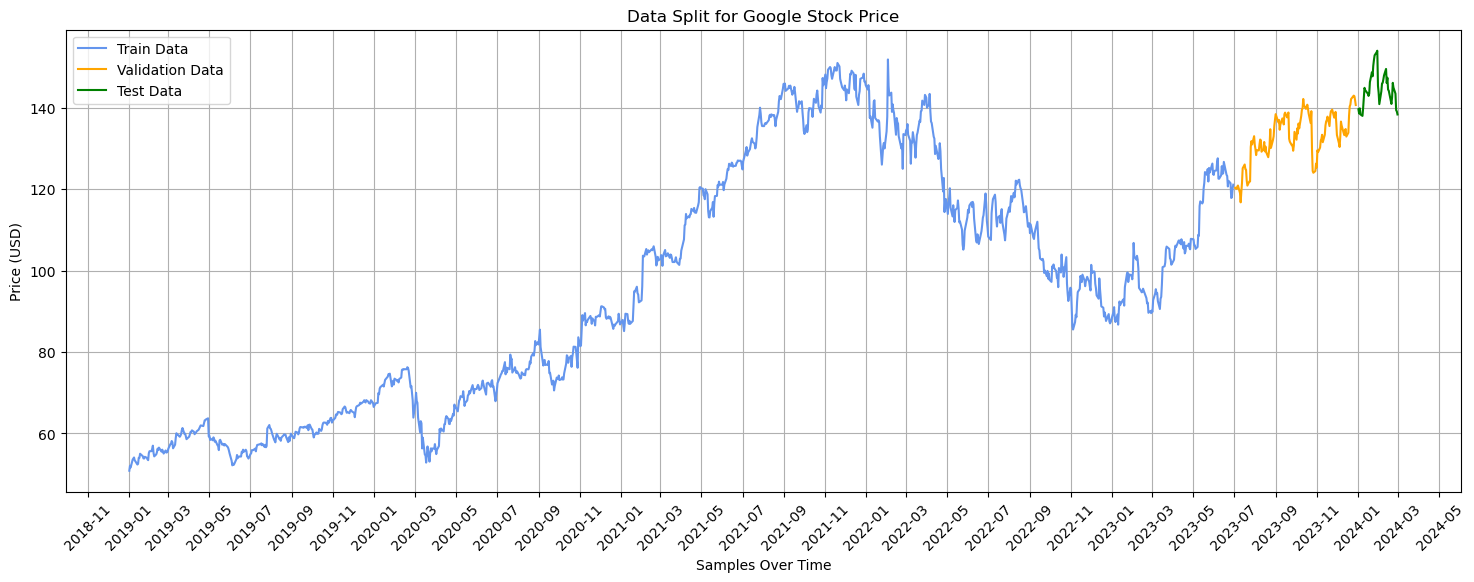

In [ ]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

### Data Scaling

In [ ]:
# Check the distribution of input features
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03
mean,100.882880,102.042442,99.853834,100.974635,100.974635,2.882756e+07
std,31.078299,31.360869,30.780336,31.059813,31.059813,1.268332e+07
min,50.828499,52.374500,50.676800,50.803001,50.803001,6.936000e+06
25%,71.211247,71.905250,70.356251,70.992001,70.992001,2.076335e+07
50%,102.825996,103.927498,101.500000,102.751503,102.751503,2.575600e+07
75%,130.778503,132.021675,129.389999,130.440002,130.440002,3.287305e+07
max,155.080002,157.000000,154.132004,156.500000,156.500000,1.241400e+08


Looking at these details, it's noticeable and anticipated that all price values exhibit similar distributions given they log the price fluctuation on daily basis.

Conversely, the trading volume presents a distinct distribution that differs significantly.

Accordingly, input features need to be transformed into a unified scale and since the distribution doesn't indicate any outliers, we will use the [0,1] range to normalize all features.

To prevent data leakage, we will fit the scaler solely to the training data. Subsequently, we will use this fitted scaler to transform the training, validation, and testing datasets.

In [ ]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

The scaler employed here will also be utilized in subsequent phases to revert the scaled data back to its original distribution. Therefore, it is essential to save this scaler to a local folder for future use.

In [ ]:
# Prepare scaler model name and location
scaler_model_location = "..//models//"
scaler_model_name = "google_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['..//models//google_stock_price_scaler.gz']

### Storing processed dataset

The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.

In [ ]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [ ]:
# Prepare datasets files and location
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

## Phase 3 : Model Building

In [ ]:
# Review the code and add appropriate commands (Karthik Ram - skr)

In [1]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
# Prepare data file location and name
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [3]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [4]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.000000  0.002422  0.001096  0.014909   0.014909  0.202348  2019-01-02
1  0.012090  0.004758  0.000269  0.000000   0.000000  0.254991  2019-01-03
2  0.007928  0.011707  0.006996  0.027351   0.027351  0.298130  2019-01-04
3  0.027184  0.013291  0.020776  0.026190   0.026190  0.279018  2019-01-07
4  0.029465  0.018586  0.023684  0.030138   0.030138  0.241988  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.687796  0.688344  0.695774  0.698226   0.698226  0.059318  2023-07-03
1  0.685223  0.711909  0.699352  0.718946   0.718946  0.092952  2023-07-05
2  0.690964  0.689648  0.691188  0.701930   0.701930  0.092117  2023-07-06
3  0.693438  0.695665  0.699654  0.694022   0.694022  0.119846  2023-07-07
4  0.675424  0.668791  0.664880  0.661292   0.661292  0.222041  2023-07-10
Testing Dataset:
       Open      High       Low     Close  Ad

In [5]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [6]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [7]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

Given that we are addressing a time series problem involving multiple predictors, our task involves constructing and reshaping the input data to suit the LSTM model.

This entails setting a sliding time window (sequence size) that determines the number of past observations used to predict the subsequent value.

In this experiment, we employ a sequence of previous samples (financial days) of all variables to forecast the opening price on the following day.

In [8]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [9]:
#Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [10]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [11]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1132, 6)
> Data Train X: (1072, 60, 6)
> Data Train y: (1072,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


### Training the lstm model

#### Building the model

In [12]:
# Initializing the model
regressor = Sequential()

In [13]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [14]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [15]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [16]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [17]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [18]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [19]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

#### Training Model

In [20]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [21]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
17/17 [==============================] - 10s 320ms/step - loss: 0.0404 - val_loss: 0.0306
Epoch 2/200
17/17 [==============================] - 4s 254ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 3/200
17/17 [==============================] - 4s 252ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 4/200
17/17 [==============================] - 4s 264ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 5/200
17/17 [==============================] - 4s 261ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 6/200
17/17 [==============================] - 4s 252ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/200
17/17 [==============================] - 5s 278ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/200
17/17 [==============================] - 5s 272ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 9/200
17/17 [==============================] - 4s 251ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 10/200
17/17 [==============================] - 4s 244ms/step - loss: 0.0039 - val_l

In [25]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

#### Performance Evaluation

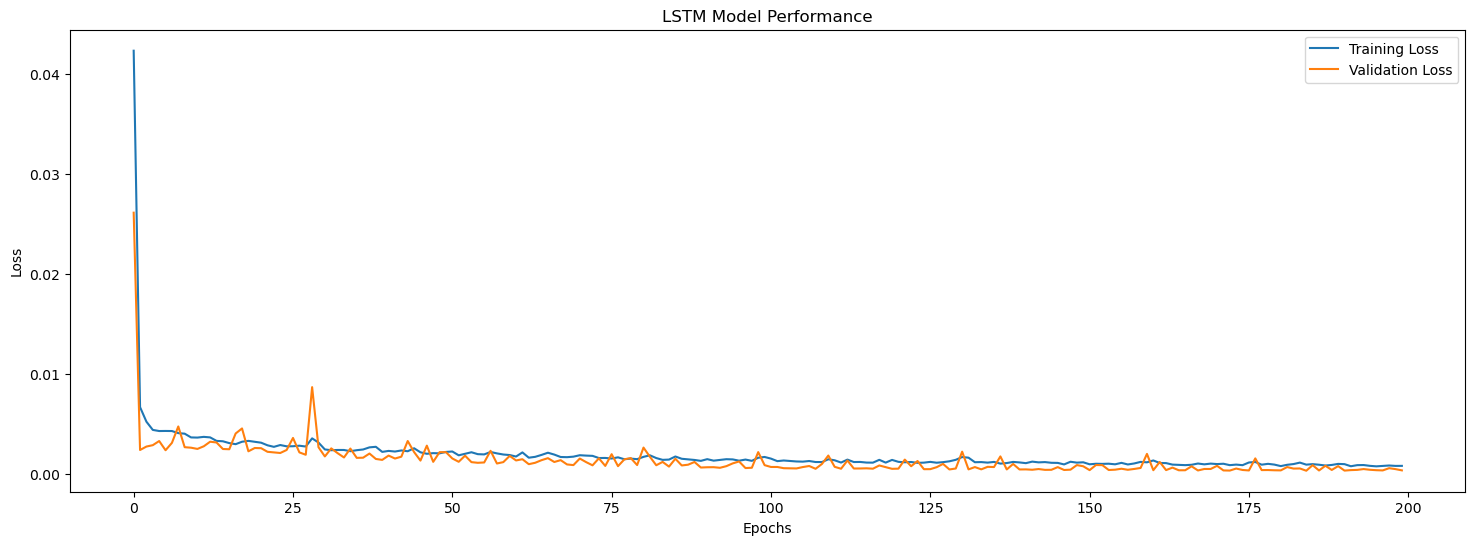

In [ ]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


The chart above highlights the following observations:

- Training loss values decrease over the epochs, starting from a higher value and gradually decreasing. This indicates that the model is learning to fit the training data better as training progresses.
- Similarly, the validation loss values also decrease initially, indicating improvement in the model's ability to generalize to unseen data (validation set).
- Some fluctuations in the validation loss have been observed, which is quite justifiable due to the high variations and complexity in the price performance over time.
- There are no signs of overfitting since both loss values are continuously decreasing along with each other over the epochs.
- Validation loss has maintained lower values than training loss across almost the whole training period, which is quite normal due to the complexity/size of training data.

## Model Explainability (with SHAP (SHapley Additive exPlanations))

In [ ]:
regressor.save("lstm_stock_model.h5")  # Save the trained model
model = load_model("lstm_stock_model.h5")  # Reload the model for SHAP

In [ ]:
# Select 100 samples as background data
background_data = X_train[:100]

# Select 10 samples to analyze model predictions
test_samples = X_test[:10]

### SHAP Explainer

In [ ]:
explainer = shap.GradientExplainer(model, background_data)

### Computing the SHAP Values

In [ ]:
# Reshape 3D LSTM input into 2D format for SHAP visualization
test_samples_2d = test_samples.reshape(test_samples.shape[0], -1)

In [ ]:
shap_values_2d = np.array(shap_values).reshape(test_samples.shape[0], -1)

### Feature Importance

In [ ]:
original_feature_names = data_train_df.columns

C:\Users\msaak\AppData\Local\Temp\ipykernel_21472\3637776920.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, test_samples_2d, feature_names=feature_names)


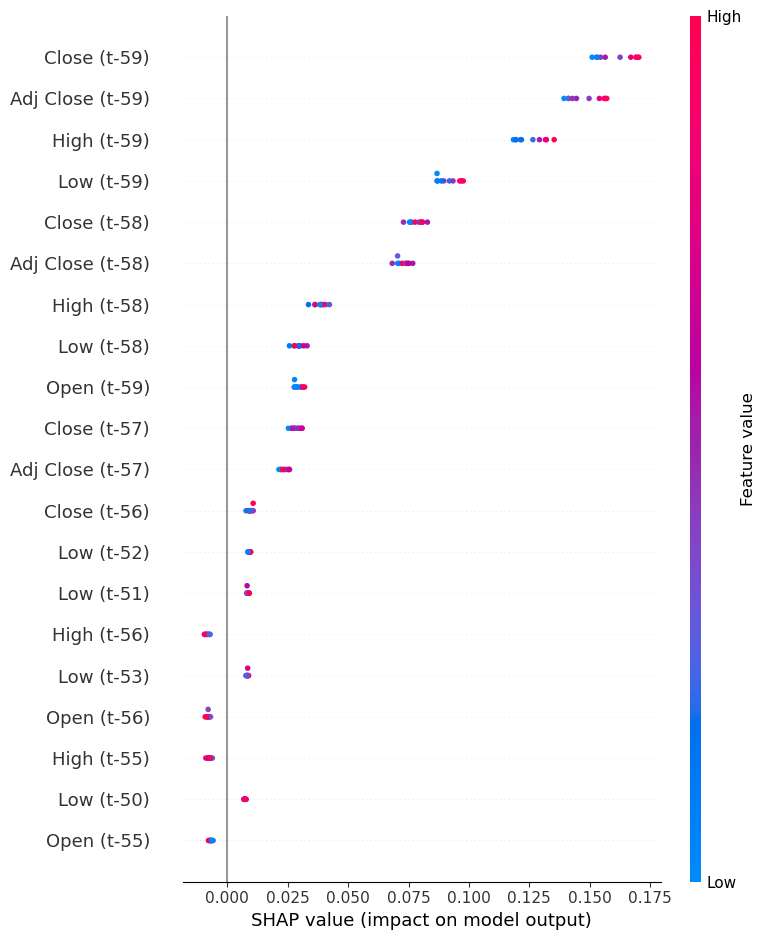

In [ ]:
time_steps = X_train.shape[1]   # 50
num_features = X_train.shape[2]  # 7

# Generate feature names in (time_step, feature) format
feature_names = [
    f"{original_feature_names[f]} (t-{t})"
    for t in range(time_steps)
    for f in range(num_features)
]

# Use this for SHAP visualization
shap.summary_plot(shap_values_2d, test_samples_2d, feature_names=feature_names)


## PHASE 4 : MODEL INFERENCE

In [ ]:
## Start with Model Inference and prediction (Aniketha P - AP)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

# Load the trained LSTM model
model_path = "/content/drive/MyDrive/NNDL/Multivariate-Stock-Price-Forecasting/notebooks/lstm_stock_model.h5"
model = load_model(model_path)

# Display Model Summary
print("\n LSTM Model Summary:\n")
model.summary()


 LSTM Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 284,103 (1.08 MB)

 Trainable params: 284,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

**Model Inference & Prediction**

For time series forecasting, the model requires sequential input data. The script prepares test data by creating sequences of 60-time steps, meaning each prediction is based on the past 60 days of stock price movements. A sliding window approach is used to generate overlapping sequences from the dataset. The target variable, which is the "Open" price at each prediction step, is also stored in a separate array. Finally, the input data is reshaped to match the expected input format of the LSTM model: a three-dimensional array consisting of samples, time steps, and features.With the prepared test data, the LSTM model is used to make predictions. Since the predictions are in a scaled format (due to MinMaxScaler), they must be inverse-transformed to obtain real stock prices. To accomplish this, a dummy array with the same shape as the original dataset is created, with only the first column (representing the "Open" price) filled with the model’s predictions. The inverse transformation is then applied to restore the actual price values. This step ensures that the predictions can be directly compared with the real-world stock prices.

In [38]:
# Load the stock price dataset
data_file = "/content/drive/MyDrive/NNDL/Multivariate-Stock-Price-Forecasting/data/raw/google_stock_price_full.csv"
df = pd.read_csv(data_file)

# Define the same feature columns used in training
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
target = "Open"  # The model predicts the "Open" price

# Scale the input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features].values)

# Prepare input data for inference (use last 60 timesteps)
look_back = 60
X_test, y_actual = [], []
for i in range(len(scaled_data) - look_back):
    X_test.append(scaled_data[i:i + look_back])
    y_actual.append(scaled_data[i + look_back, 0])  # True 'Open' price in scaled form

X_test = np.array(X_test)
y_actual = np.array(y_actual)

# Ensure correct shape for inference
X_test = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))

# Perform inference
predicted_scaled = model.predict(X_test)

# Inverse transform only the "Open" price predictions
dummy_array = np.zeros((predicted_scaled.shape[0], len(features)))  # Create a dummy array
dummy_array[:, 0] = predicted_scaled[:, 0]  # Fill the first column (Open)
predicted_stock_price = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the "Open" column

# Inverse transform actual values
dummy_actual = np.zeros((y_actual.shape[0], len(features)))
dummy_actual[:, 0] = y_actual
actual_stock_price = scaler.inverse_transform(dummy_actual)[:, 0]

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


153/153 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step


**Model Performance Evaluation**


To measure the accuracy of the predictions, three key evaluation metrics are calculated:

Mean Absolute Error (MAE): Measures the average absolute difference between actual and predicted stock prices, providing an intuitive understanding of the model’s error.

Root Mean Squared Error (RMSE): Penalizes larger errors more than MAE, making it useful for identifying significant deviations in predictions.

Mean Absolute Percentage Error (MAPE): Expresses the error as a percentage of the actual values, allowing for easier interpretation across different price ranges.

In [39]:
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
mape = np.mean(np.abs((actual_stock_price - predicted_stock_price) / actual_stock_price)) * 100

print(f"\n Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error)    : {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error)  : {mape:.2f}%")


 Model Evaluation Metrics:
MAE  (Mean Absolute Error)    : 0.8055
RMSE (Root Mean Squared Error): 1.2090
MAPE (Mean Absolute % Error)  : 2.27%


**Visualization of Predictions**

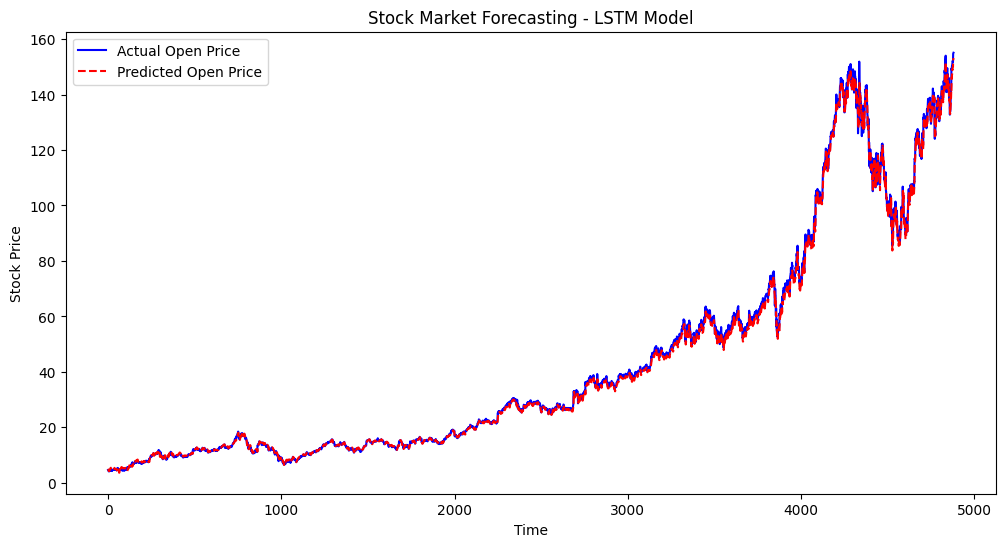

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label="Actual Open Price", color='blue')
plt.plot(predicted_stock_price, label="Predicted Open Price", linestyle="dashed", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Market Forecasting - LSTM Model")
plt.show()

**Uncertainty Estimation & Confidence Interval**

Since stock market forecasting involves uncertainty, the script approximates confidence intervals for the predictions. By calculating the standard deviation of the prediction errors, a 95% confidence interval is estimated using the formula:

 Upper Bound = Prediction + (1.96 × Standard Deviation) <br>Lower Bound = Prediction − (1.96 × Standard Deviation)<br>
These confidence intervals provide an estimate of the range within which future stock prices are likely to fall. The plot includes shaded regions representing these intervals, allowing analysts to visualize the level of certainty in the model’s predictions.

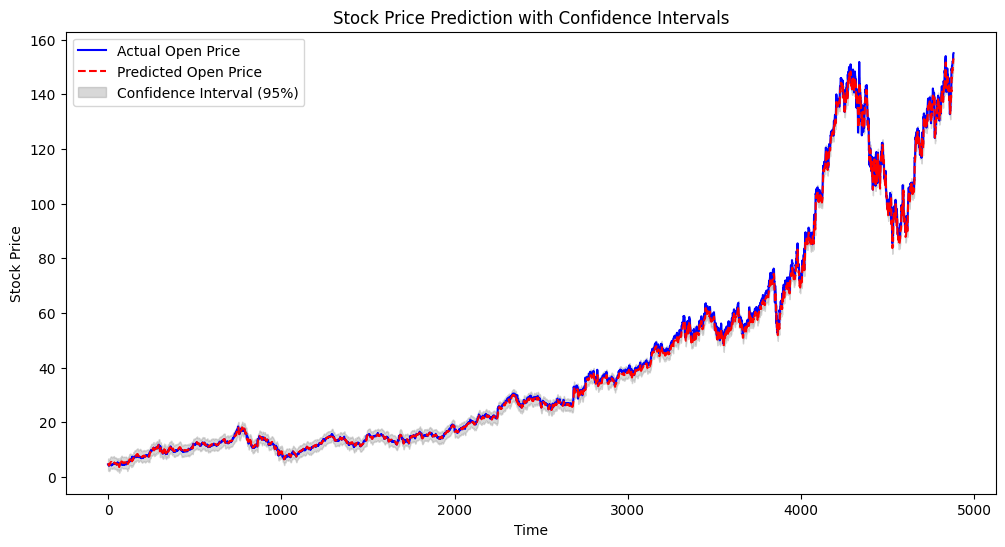

In [41]:
error = actual_stock_price - predicted_stock_price
std_dev = np.std(error)
upper_bound = predicted_stock_price + (1.96 * std_dev)
lower_bound = predicted_stock_price - (1.96 * std_dev)

plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label="Actual Open Price", color='blue')
plt.plot(predicted_stock_price, label="Predicted Open Price", linestyle="dashed", color='red')
plt.fill_between(range(len(predicted_stock_price)), lower_bound, upper_bound, color='gray', alpha=0.3, label="Confidence Interval (95%)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction with Confidence Intervals")
plt.show()

In [31]:
from numpy import mean

naive_forecast = actual_stock_price[:-1]  # Simple shift as naive forecast
naive_error = mean(np.abs(actual_stock_price[1:] - naive_forecast))
mase = mae / naive_error
print(f"MASE (Mean Absolute Scaled Error): {mase:.4f}")


MASE (Mean Absolute Scaled Error): 1.4381


In [32]:
smape = np.mean(2 * np.abs(actual_stock_price - predicted_stock_price) /
               (np.abs(actual_stock_price) + np.abs(predicted_stock_price))) * 100
print(f"SMAPE (Symmetric MAPE): {smape:.2f}%")


SMAPE (Symmetric MAPE): 2.27%


In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_stock_price, predicted_stock_price)
print(f"R² Score: {r2:.4f}")


R² Score: 0.9991


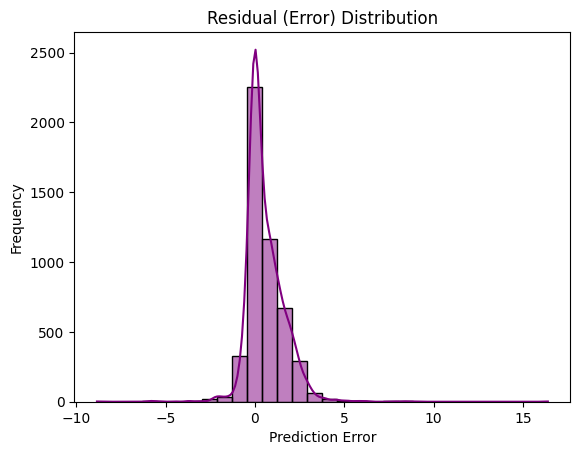

In [34]:
residuals = actual_stock_price - predicted_stock_price
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residual (Error) Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


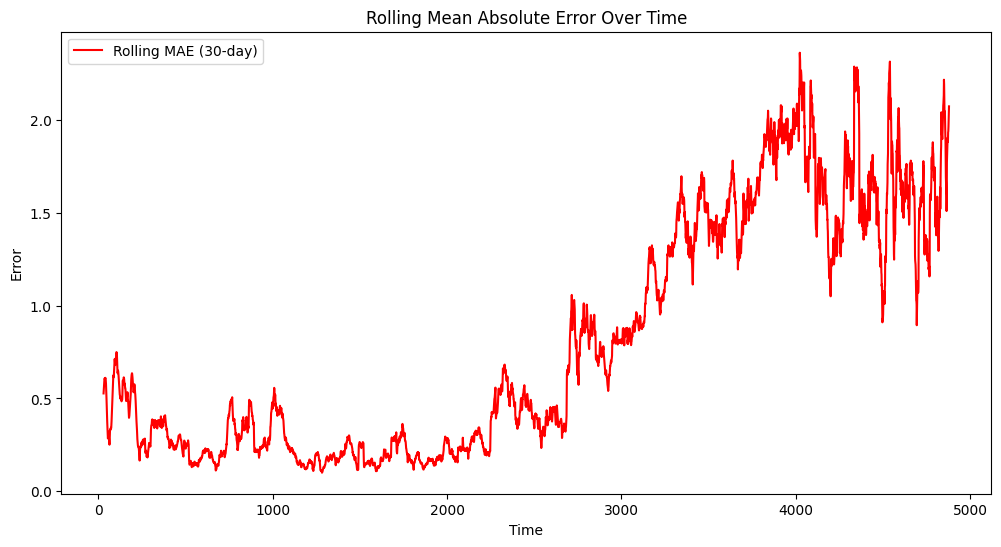

In [36]:
rolling_mae = pd.Series(np.abs(residuals)).rolling(window=30).mean()
plt.figure(figsize=(12, 6))
plt.plot(rolling_mae, label="Rolling MAE (30-day)", color='red')
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Rolling Mean Absolute Error Over Time")
plt.legend()
plt.show()


# PHASE 5 : TENSORBOARD

In [42]:
## Start with Tensorboard (Riya)

### 📊 **Visualizing Model Performance with TensorBoard**

### **Objective**
This phase focuses on **understanding how model changes impact performance using TensorBoard**.

### **Steps**
1. **Load and preprocess data** for LSTM models.  
2. **Train three models**:  
   - Simple LSTM  
   - Advanced Regressor  
   - Optimized LSTM  
3. **Log metrics** like loss and MSE for real-time tracking.  
4. **Compare actual vs. predicted values**.  
5. **Analyze insights in TensorBoard** to improve model performance.  

🚀 Let's begin!  


In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


### **Data Preprocessing for LSTM** 

### **Overview**  
Prepares stock price data for LSTM training.  

### **Steps**  
1. **Load Data**: Read train, validation, and test CSVs.  
2. **Format Dates**: Convert `Date` column to datetime.  
3. **Extract Features**: Select `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`.  
4. **Scale Data**: Normalize features for LSTM.  
5. **Create Sequences**: Generate `X` (60 time steps) & `y` (target).  
6. **Split Data**: Form **train, validation, and test** sets.  

### **Output**  
Displays dataset shapes for verification.  


In [ ]:
# Data file locations
data_file_location = r"E:\NNDL\Multivariate-Stock-Price-Forecasting\data\processed"
data_file_ext = "csv"

# Load data
data_train_df = pd.read_csv(os.path.join(data_file_location, "google_stock_price_processed_train." + data_file_ext))
data_validate_df = pd.read_csv(os.path.join(data_file_location, "google_stock_price_processed_validate." + data_file_ext))
data_test_df = pd.read_csv(os.path.join(data_file_location, "google_stock_price_processed_test." + data_file_ext))

# Convert Date column to datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

# Extract features
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

# Define sequence size
sequence_size = 60

# Function to construct LSTM data sequences
def construct_lstm_data(data, sequence_size, target_attr_idx):
    X, y = [], []
    for i in range(sequence_size, len(data)):
        X.append(data[i-sequence_size:i, :])
        y.append(data[i, target_attr_idx])
    return np.array(X), np.array(y)

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

# Combine all scaled datasets
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Construct validation and test datasets
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size, :], sequence_size, 0)
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):, :], sequence_size, 0)

# Check data shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validate: {X_validate.shape}, {y_validate.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: (1072, 60, 6), (1072,)
Validate: (126, 60, 6), (126,)
Test: (41, 60, 6), (41,)


## 📊 TensorBoard Logging & Training  

- **Logs:** `logs/fit/Simple_LSTM_<timestamp>`  
- **Model:** 2 LSTMs, Dropout, Dense layers  
- **Logging:** Tracks loss trends, compares models, optimizes hyperparameters, and helps debug efficiently using **TensorBoard & Model Checkpoint (`val_loss`)**.  
- **Training:** 50 epochs, batch size 64  
- **Saves:** Best & final model  


In [7]:
# Define log directory for TensorBoard
base_log_dir = r"E:\NNDL\Multivariate-Stock-Price-Forecasting\logs\fit"
log_dir_simple = os.path.join(base_log_dir, "Simple_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Define simple LSTM model
simple_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
simple_model.compile(optimizer="adam", loss="mean_squared_error")

# Callbacks for simple model
tensorboard_callback_simple = TensorBoard(log_dir=log_dir_simple, histogram_freq=1)
model_checkpoint_simple = ModelCheckpoint(
    r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\simple_lstm_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

# Train the simple model
history_simple = simple_model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=50,
    batch_size=64,
    callbacks=[tensorboard_callback_simple, model_checkpoint_simple]
)

# Save the model
simple_model.save(r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\simple_lstm_model_final.h5")


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.1520 - val_loss: 0.0619
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0147 - val_loss: 0.0020
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss:

In [4]:
# Evaluate the model on the validation set
loss = simple_model.evaluate(X_validate, y_validate)

# Print results
print(f"\n✅ Simple LSTM Model Evaluation:")
print(f"Validation Loss: {loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.9616e-04

✅ Simple LSTM Model Evaluation:
Validation Loss: 0.0009


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   


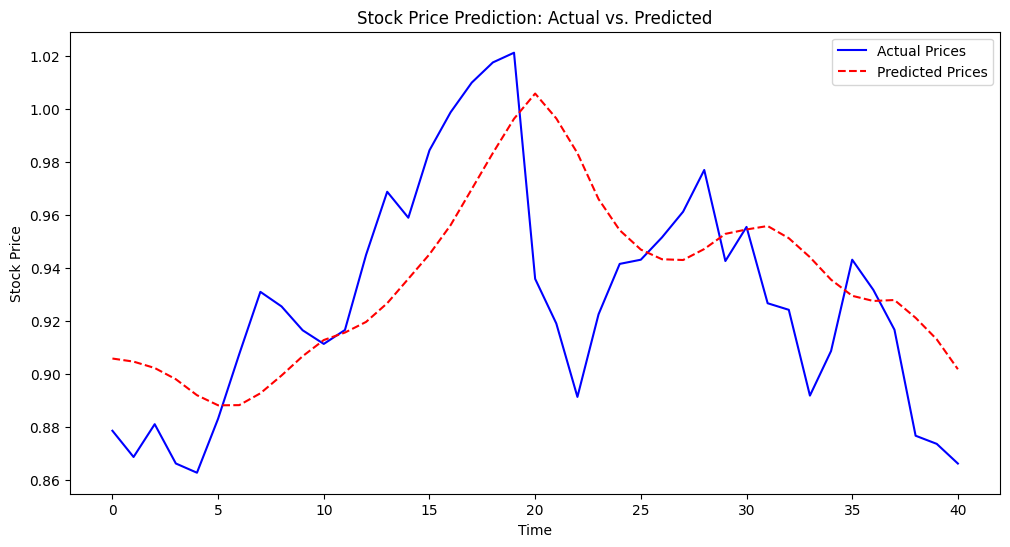

In [8]:
import matplotlib.pyplot as plt

# Predict stock prices using the test data
y_test_pred = simple_model.predict(X_test)

# Plot Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_test_pred, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.title("Stock Price Prediction: Actual vs. Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


## Enhanced LSTM Model for Stock Price Prediction  

### 🔹 Model Overview  
- **Architecture**:  
  - Bidirectional LSTM (128) → BatchNorm → Dropout (0.2)  
  - Bidirectional LSTM (128) → BatchNorm → Dropout (0.2)  
  - LSTM (64) → Dropout (0.2)  
  - Dense (50, ReLU) → Dense (1)  

- **Optimization**:  
  - Loss: Huber  
  - Optimizer: Adam (LR=0.001)  

###  Callbacks  
- **TensorBoard**: `logs/fit/Enhanced_LSTM_<timestamp>`  
- **Early Stopping**: `patience=15`  
- **Reduce LR**: `factor=0.5, patience=5, min_lr=1e-5`  
- **Model Checkpoint**: Best model saved as `enhanced_lstm_model.keras`  

###  Training  
- **Epochs**: 150  
- **Batch Size**: 64  
- **Final Model**: `enhanced_lstm_model_final.h5`  


In [9]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

# Define log directory for TensorBoard
base_log_dir = r"E:\NNDL\Multivariate-Stock-Price-Forecasting\logs\fit"
log_dir_enhanced = os.path.join(base_log_dir, "Enhanced_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Define Enhanced LSTM Model
enhanced_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Bidirectional(LSTM(units=128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(units=128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),

    LSTM(units=64, return_sequences=False),
    Dropout(0.2),

    Dense(units=50, activation="relu"),
    Dense(units=1)
])

# Compile with Huber Loss & Adam Optimizer (Lower LR)
enhanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.Huber())

# Callbacks
tensorboard_callback_enhanced = TensorBoard(log_dir=log_dir_enhanced, histogram_freq=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1)

model_checkpoint_enhanced = ModelCheckpoint(
    r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\enhanced_lstm_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

# Train Enhanced Model
history_enhanced = enhanced_model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=150,  # Slightly more epochs for better learning
    batch_size=64,
    callbacks=[tensorboard_callback_enhanced, early_stopping, reduce_lr, model_checkpoint_enhanced]
)

# Save the final model
enhanced_model.save(r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\enhanced_lstm_model_final.h5")


Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 688ms/step - loss: 0.0711 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 521ms/step - loss: 0.0097 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 522ms/step - loss: 0.0073 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - loss: 0.0067 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 504ms/step - loss: 0.0051 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 537ms/step - loss: 0.0038 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 548ms/step - loss: 0.0038 - val_loss: 0.0410 - learning_rate: 0.0010
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - loss: 0.0034 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 9/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - loss: 0.0031 - val_loss: 0.0356 - learning_rate: 0.0010

C:\Users\riyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


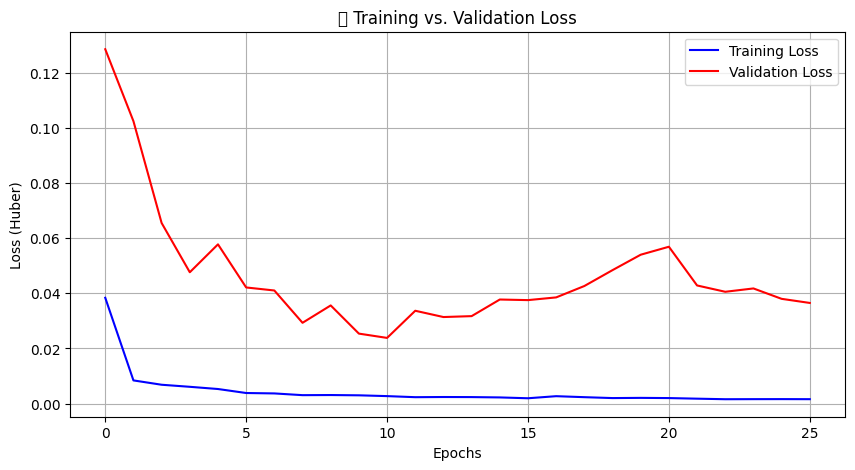

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000206C2AC62A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


C:\Users\riyar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


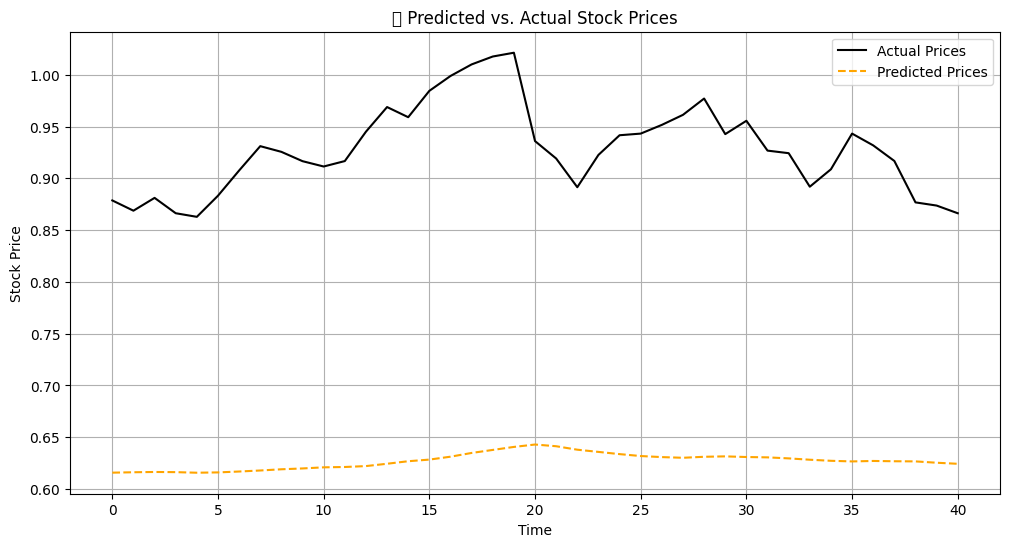

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history_enhanced.history['loss'], label='Training Loss', color='blue')
plt.plot(history_enhanced.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss (Huber)')
plt.title('📉 Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Learning Rate Reduction
if 'lr' in history_enhanced.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history_enhanced.history['lr'], label='Learning Rate', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('🔄 Learning Rate Adjustment')
    plt.legend()
    plt.grid()
    plt.show()

# Predict on Test Data
y_pred = enhanced_model.predict(X_test)

# Plot Predicted vs. Actual Stock Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual Prices', color='black')
plt.plot(y_pred[:100], label='Predicted Prices', color='orange', linestyle="dashed")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('📈 Predicted vs. Actual Stock Prices')
plt.legend()
plt.grid()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


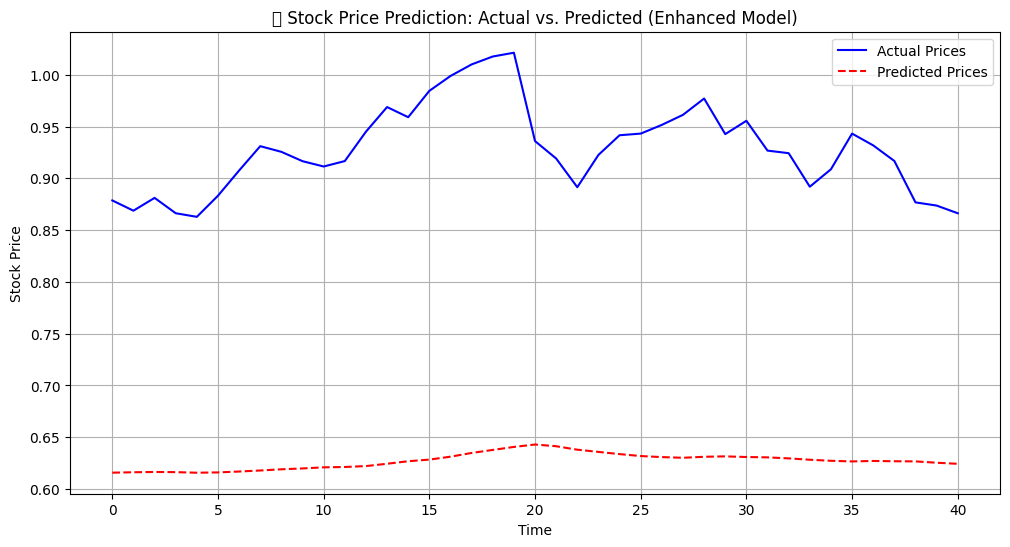

In [11]:
import matplotlib.pyplot as plt

# Predict stock prices using the test data
y_test_pred = enhanced_model.predict(X_test)

# Plot Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_test_pred, label="Predicted Prices", color='red', linestyle='dashed')

# Formatting
plt.title("📈 Stock Price Prediction: Actual vs. Predicted (Enhanced Model)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()


##  Regressor LSTM Model for Stock Price Prediction  

### 🔹 Model Overview  
- **Architecture**:  
  - LSTM (100) → Dropout (0.2) → LSTM (100) → Dropout (0.2)  
  - LSTM (100) → Dropout (0.2) → LSTM (100) → Dropout (0.2)  
  - Dense (1) for final prediction  

- **Optimization**:  
  - Loss: Mean Squared Error (MSE)  
  - Optimizer: Adam  

###  Callbacks  
- **TensorBoard**: `logs/fit/Regressor_LSTM_<timestamp>`  
- **Model Checkpoint**: Saves best model (`regressor_lstm_model.keras`)  

### Training  
- **Epochs**: 200  
- **Batch Size**: 64  
- **Final Model**: `regressor_lstm_model_final.h5`  


In [12]:
# Define log directory for TensorBoard
log_dir_regressor = os.path.join(base_log_dir, "Regressor_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Define Regressor LSTM model
regressor = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=100, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=100),
    Dropout(rate=0.2),
    Dense(units=1)
])

# Compile the model
regressor.compile(optimizer="adam", loss="mean_squared_error")

# Callbacks for regressor model
tensorboard_callback_regressor = TensorBoard(log_dir=log_dir_regressor, histogram_freq=1)
model_checkpoint_regressor = ModelCheckpoint(
    r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\regressor_lstm_model.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

# Train the regressor model
history_regressor = regressor.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size=64,
    callbacks=[tensorboard_callback_regressor, model_checkpoint_regressor]
)

# Save the regressor model
regressor.save(r"E:\NNDL\Multivariate-Stock-Price-Forecasting\models\regressor_lstm_model_final.h5")


Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 580ms/step - loss: 0.1041 - val_loss: 0.0353
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step - loss: 0.0121 - val_loss: 0.0027
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - loss: 0.0064 - val_loss: 0.0022
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 421ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 420ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 422ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


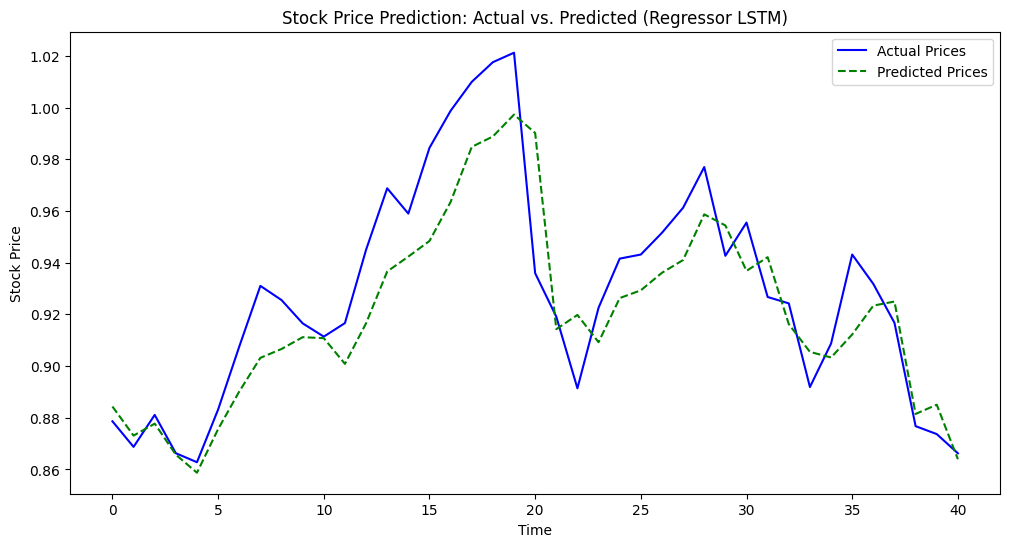

In [13]:
import matplotlib.pyplot as plt

# Predict stock prices using the test data
y_test_pred_regressor = regressor.predict(X_test)

# Plot Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color='blue', linestyle='solid')
plt.plot(y_test_pred_regressor, label="Predicted Prices", color='green', linestyle='dashed')

# Formatting
plt.title("Stock Price Prediction: Actual vs. Predicted (Regressor LSTM)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


##  Custom TensorBoard Callback for Enhanced Visualization  

### 🔹 Overview  
This custom TensorBoard callback logs additional metrics and visualizations to improve model evaluation during training.

###  Features  
- **Logs Key Metrics**:  
  - **Mean Squared Error (MSE)**  
  - **Mean Absolute Error (MAE)**  
  - **Root Mean Squared Error (RMSE)**  

- **Generates Plots**:  
  - Plots **Actual vs. Predicted** values for better insight  
  - Converts plots into TensorBoard-compatible images  

###  How It Works  
1. At the end of each epoch, the model predicts on the validation set.  
2. MSE, MAE, and RMSE are computed and logged to TensorBoard.  
3. A visualization of predicted vs. actual values is generated.  
4. The plot is saved and converted into an image for TensorBoard.  
5. The writer flushes data to ensure logs are properly recorded.  

###  Usage  
- Set `log_dir` to store logs.  
- Provide `X_val` and `y_val` for validation data logging.  
- Add the callback while training the model.  

###  Benefits  
✅ **Real-time tracking of validation performance**  
✅ **Better insights into model convergence**  
✅ **Integrated visualization for quick debugging**  


In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io

# Custom TensorBoard Callback
class CustomTensorBoard(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, X_val, y_val):
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(log_dir)
        self.X_val = X_val  # Store validation set
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)  # Predict on validation set
        
        # Compute different error metrics
        mse = np.mean(tf.keras.losses.MSE(self.y_val, y_pred).numpy())  
        mae = np.mean(tf.keras.losses.MAE(self.y_val, y_pred).numpy())  
        rmse = np.sqrt(mse)  # Root Mean Squared Error
        
        with self.writer.as_default():
            tf.summary.scalar("MSE", mse, step=epoch)
            tf.summary.scalar("MAE", mae, step=epoch)
            tf.summary.scalar("RMSE", rmse, step=epoch)

            # Plot Actual vs Predicted
            fig, ax = plt.subplots()
            ax.plot(self.y_val[:100], label="Actual")
            ax.plot(y_pred[:100], label="Predicted", linestyle="dashed")
            ax.legend()

            # Convert Matplotlib figure to TensorBoard image
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            tf.summary.image("Predicted vs Actual", image, step=epoch)

            plt.close(fig)  # Close plot to free memory

        self.writer.flush()


In [16]:
import datetime
import os

base_log_dir = r"E:\NNDL\Multivariate-Stock-Price-Forecasting\logs\fit"

log_dir_simple = os.path.join(base_log_dir, "Simple_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir_enhanced = os.path.join(base_log_dir, "Enhanced_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir_regressor = os.path.join(base_log_dir, "Regressor_LSTM_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))





In [17]:
# Create separate callbacks for each model
tensorboard_callback_simple = CustomTensorBoard(log_dir_simple, X_validate, y_validate)
tensorboard_callback_enhanced = CustomTensorBoard(log_dir_enhanced, X_validate, y_validate)
tensorboard_callback_regressor = CustomTensorBoard(log_dir_regressor, X_validate, y_validate)


In [18]:
# Train Simple Model
history_simple = simple_model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=50,
    batch_size=64,
    callbacks=[tensorboard_callback_simple]
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step ep - loss: 9.1116e
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 9.1447e-04 - val_loss: 0.0012
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step ep - loss: 0.0
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/steptep - loss: 9.6047e-
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 9.6030e-04 - val_loss: 0.0014
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step ep - loss: 9.8528e
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - loss: 9.8885e-04 - val_loss: 0.0012
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/steptep - loss: 9.4401e-
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 9.4756e-04 - val_loss: 0.0011
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step ep - loss: 0.0
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step ep - loss: 9.4718e
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 9.4399e-04 - va

In [19]:


# Train Enhanced Model
history_enhanced = enhanced_model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=100,
    batch_size=64,
    callbacks=[tensorboard_callback_enhanced]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/stepep - loss: 
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - loss: 0.0025 - val_loss: 0.0293
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/stepep - loss: 0
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - loss: 0.0028 - val_loss: 0.0296
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepep - loss: 0
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 551ms/step - loss: 0.0025 - val_loss: 0.0325
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stepep - loss: 0
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 559ms/step - loss: 0.0019 - val_loss: 0.0341
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stepep - loss: 0
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - loss: 0.0022 - val_loss: 0.0355
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/stepep - loss:
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 560ms/step - loss: 0.0022 - val_loss: 0.0364
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/stepep - loss
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 588ms/step - loss: 0.0020 - val_loss: 0.0409
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━

In [20]:

# Train Regressor Model
history_regressor = regressor.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    epochs=100,
    batch_size=64,
    callbacks=[tensorboard_callback_regressor]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step ep - loss: 7.690
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step - loss: 7.7404e-04 - val_loss: 3.7404e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/steptep - loss: 8.1707
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 8.1795e-04 - val_loss: 2.9060e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step ep - loss: 7.0968
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 7.1230e-04 - val_loss: 3.9243e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/steptep - loss: 8.5575e
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - loss: 8.6063e-04 - val_loss: 3.9205e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/stepep - loss
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 972ms/step - loss: 0.0011 - val_loss: 3.7254e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step- loss: 8.
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 8.8245e-04 - val_loss: 4.2383e-04
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/stepep - loss: 8.
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 794ms/step - loss: 

##  Model Training & TensorBoard Logging  

### 🔹 Overview  
Three different LSTM-based models were trained to compare performance on stock price prediction:  

1. **Simple LSTM** – A basic stacked LSTM model  
2. **Enhanced LSTM** – A more advanced bidirectional LSTM with batch normalization  
3. **Regressor LSTM** – A deep LSTM model with multiple stacked layers  

Each model was trained separately while logging key metrics and visualizations to TensorBoard.

###  Model Training Flow  
- **Each model was trained independently** using different architectures.  
- **Callbacks were assigned** to save the best model and log training progress.  
- **Training, validation losses, and learning rates** were recorded in TensorBoard.  

###  TensorBoard Visualization  
- **Logs are stored in separate directories** under `logs/fit/` with unique timestamps:  
  - `Simple_LSTM_<timestamp>`  
  - `Enhanced_LSTM_<timestamp>`  
  - `Regressor_LSTM_<timestamp>`  

- **What can be viewed in TensorBoard?**  
  ✅ Loss curves (Training vs. Validation)  
  ✅ Learning rate adjustments over epochs  
  ✅ Histograms of model weights & activations  
  ✅ Actual vs. Predicted stock price plots (via custom callback)  

###  How to Open TensorBoard  
Run the following command in the terminal (replace with the correct path to your logs folder):  
```sh
tensorboard --logdir=E:\NNDL\Multivariate-Stock-Price-Forecasting\logs\fit
```

### 📍 Steps to Access TensorBoard:

1. Run the above command in your terminal.  
2. Wait for TensorBoard to start (it will display a link).  
3. **Click on the localhost link** that appears in the terminal (e.g., `http://localhost:6006`).  
4. This will open TensorBoard in your browser, where you can navigate different tabs to analyze:  
   - 📊 **Training & Validation Loss Curves**  
   - 🔄 **Learning Rate Adjustments**  
   - 📈 **Model Graphs & Histograms**  
   - 🎯 **Actual vs. Predicted Stock Prices**  


